# Executive Summary
## Readmission Rates vs Features
In this section we are looking at readmission rate vs the following features
- Gender
- Age
- Admission Types
- Discharge Disposition

We are also looking at how much resources are being taken up by these readmissions such as 
- Number of Medications
- Number of Lab Procedures
- Number of Inpatients (patients who stay the night)
- Number of Emergencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pandas as pd
import numpy as np


## 1. Load & Explore Data

In [70]:
# CONECCTING TO SQL
# Database connection settings
DB_USER = ''
DB_PASSWORD = ''
DB_HOST = 'localhost'
DB_PORT = ''
DB_NAME = 'ClinicalTrials'
TABLE_NAME = 'readmissions'
CSV_FILE_PATH = 'readmission_dataset.csv'

In [2]:
# Create a SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# Test it by loading a small preview
df = pd.read_sql("SELECT * FROM uci_diabetes_readmissions LIMIT 5", engine)
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# PULLING AND STORING KEY TABLES
readmissions = pd.read_sql("SELECT * FROM uci_diabetes_readmissions", engine)
admission_type = pd.read_sql("SELECT * FROM admission_type_lookup", engine)
admission_source = pd.read_sql("SELECT * FROM admission_source_lookup", engine)
discharge_disposition = pd.read_sql("SELECT * FROM discharge_disposition_lookup", engine)


In [4]:
# CLEANING AND JOINING DATA
readmissions['admission_type_id'] = readmissions['admission_type_id'].astype('Int64')
readmissions['admission_source_id'] = readmissions['admission_source_id'].astype('Int64')
readmissions['discharge_disposition_id'] = readmissions['discharge_disposition_id'].astype('Int64')

# Join with lookup tables
df = readmissions.merge(admission_type, on='admission_type_id', how='left') \
                 .merge(admission_source, on='admission_source_id', how='left') \
                 .merge(discharge_disposition, on='discharge_disposition_id', how='left')


In [5]:
# CALCULATE READMISSION RATES
df['readmitted_flag'] = df['readmitted'].apply(lambda x: 1 if x == 'YES' or x == '<30' else 0)

readmit_by_gender = df.groupby('gender')['readmitted_flag'].agg(['count', 'sum'])
readmit_by_gender['readmission_rate'] = 100 * readmit_by_gender['sum'] / readmit_by_gender['count']
readmit_by_gender

,count,sum,readmission_rate
gender,,,
Female,54708,6152,11.245156
Male,47055,5205,11.061524
Unknown/Invalid,3,0,0.000000


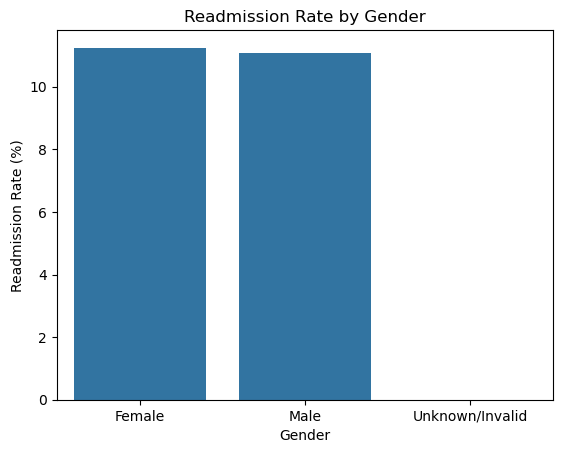

In [55]:
# PLOT READMISSION RATES


sns.barplot(x=readmit_by_gender.index, y=readmit_by_gender['readmission_rate'])
plt.title("Readmission Rate by Gender")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Gender")
# plt.show()
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_gender.png')


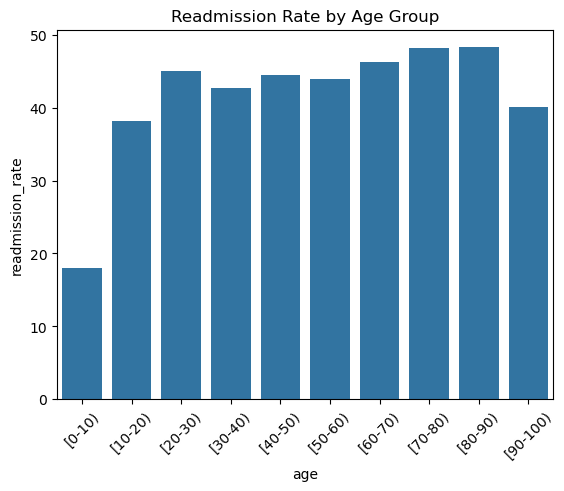

In [56]:

age_readmit = df.groupby('age')['readmitted_flag'].agg(['count', 'sum'])
age_readmit['readmission_rate'] = 100 * age_readmit['sum'] / age_readmit['count']
sns.barplot(x=age_readmit.index, y=age_readmit['readmission_rate'])
plt.title("Readmission Rate by Age Group")
plt.xticks(rotation=45)
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_age_group.png')


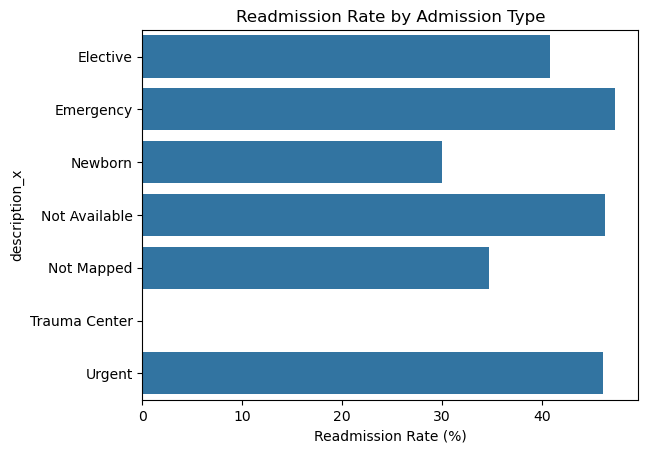

In [57]:
adm_type = df.groupby('description_x')['readmitted_flag'].agg(['count', 'sum'])  # `description_x` is admission_type
adm_type['rate'] = 100 * adm_type['sum'] / adm_type['count']
sns.barplot(y=adm_type.index, x=adm_type['rate'])
plt.title("Readmission Rate by Admission Type")
plt.xlabel("Readmission Rate (%)")
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_admission_type.png')

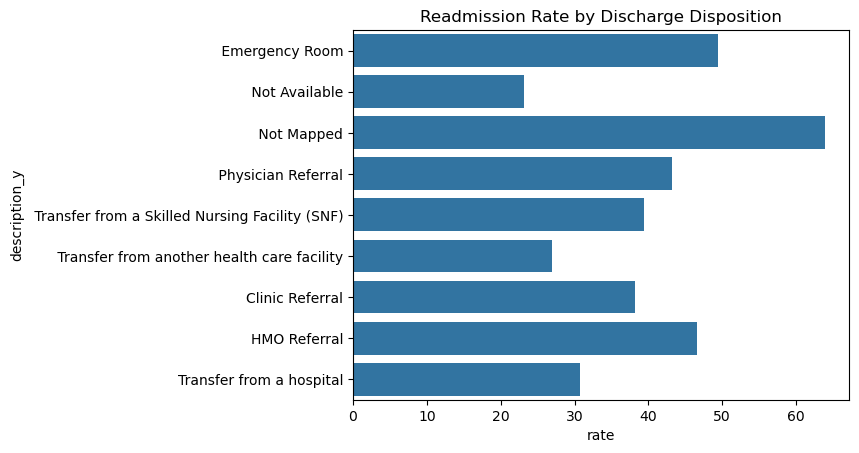

In [58]:
disp = df.groupby('description_y')['readmitted_flag'].agg(['count', 'sum'])  # `description_y` is discharge_disposition
disp['rate'] = 100 * disp['sum'] / disp['count']
disp = disp[disp['count'] > 20]  # Filter small groups
sns.barplot(y=disp.index, x=disp['rate'])
plt.title("Readmission Rate by Discharge Disposition")
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_discharge_disposition.png')

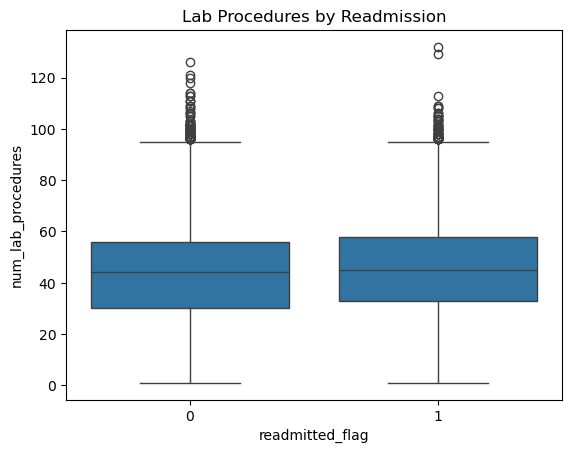

In [59]:
sns.boxplot(x='readmitted_flag', y='num_lab_procedures', data=df)
plt.title("Lab Procedures by Readmission")
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_lab_procedure.png')

In [11]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'description_x', 'description_y', 'description', 'readmitted_flag'],
      dtype='obj

In [12]:
n_medi = df.groupby('num_medications')['readmitted_flag'].agg(['count', 'sum'])  # `description_y` is discharge_disposition
n_medi['rate'] = 100 * n_medi['sum'] / n_medi['count']
n_medi

,count,sum,rate
num_medications,,,
1,262,11,4.198473
2,470,39,8.297872
3,900,65,7.222222
4,1417,114,8.045166
5,2017,150,7.436787
...,...,...,...
72,3,3,100.000000
74,1,0,0.000000
75,2,0,0.000000


C:\Users\craig\AppData\Local\Temp\ipykernel_23028\2806529666.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucketed = df.groupby('meds_bucket')['readmitted_flag'].agg(['count', 'sum'])


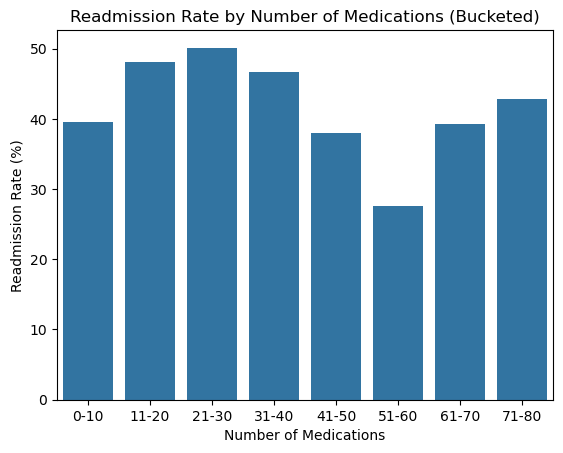

In [60]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

df['meds_bucket'] = pd.cut(df['num_medications'], bins=bins, labels=labels)

bucketed = df.groupby('meds_bucket')['readmitted_flag'].agg(['count', 'sum'])
bucketed['rate'] = 100 * bucketed['sum'] / bucketed['count']

sns.barplot(x=bucketed.index, y=bucketed['rate'])
plt.title('Readmission Rate by Number of Medications (Bucketed)')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Number of Medications')
plt.savefig('Graphs/ExploratoryGraphs/readmission_num_medications.png')

In [14]:
n_lab_proce = df.groupby('num_lab_procedures')['readmitted_flag'].agg(['count','sum'])
n_lab_proce

,count,sum
num_lab_procedures,,
1,3208,302
2,1101,126
3,668,63
4,378,24
5,286,27
...,...,...
120,1,0
121,1,0
126,1,0


C:\Users\craig\AppData\Local\Temp\ipykernel_23028\1191236694.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucketed = df.groupby('lab_proce_bucket')['readmitted_flag'].agg(['count', 'sum'])


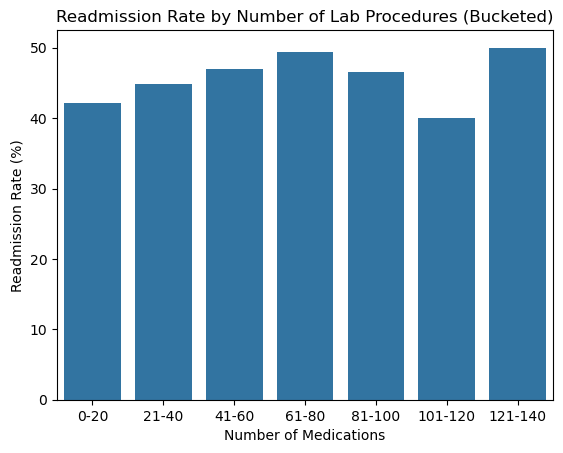

In [61]:
bins = [0, 20, 40, 60, 80, 100, 120, 140]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140']
df['lab_proce_bucket'] = pd.cut(df['num_lab_procedures'], bins=bins, labels=labels)

bucketed = df.groupby('lab_proce_bucket')['readmitted_flag'].agg(['count', 'sum'])
bucketed['rate'] = 100 * bucketed['sum'] / bucketed['count']


sns.barplot(x=bucketed.index, y=bucketed['rate'])
plt.title('Readmission Rate by Number of Lab Procedures (Bucketed)')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Number of Medications')
plt.savefig('Graphs/ExploratoryGraphs/readmission_num_lab_procedures.png')

In [16]:
n_inpatient = df.groupby('number_inpatient')['readmitted_flag'].agg(['count','sum'])
n_inpatient

,count,sum
number_inpatient,,
0,67630,5706
1,19521,2523
2,7566,1319
3,3411,692
4,1622,383
5,812,255
6,480,166
7,268,95
8,151,67


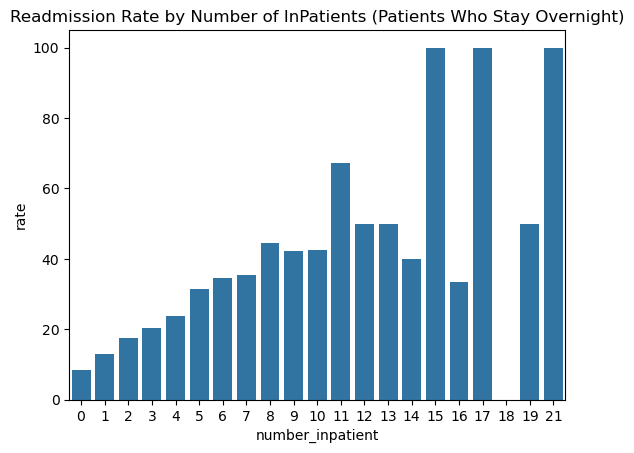

In [62]:
n_inpatient['rate'] = 100 * n_inpatient['sum'] / n_inpatient['count']
sns.barplot(x=n_inpatient.index, y=n_inpatient['rate'])
plt.title("Readmission Rate by Number of InPatients (Patients Who Stay Overnight)")
plt.savefig('Graphs/ExploratoryGraphs/readmission_num_inpatients.png')

In [18]:
n_emergency = df.groupby('number_emergency')['readmitted_flag'].agg(['count','sum'])
n_emergency

,count,sum
number_emergency,,
0,90383,9467
1,7677,1102
2,2042,373
3,725,147
4,374,115
5,192,47
6,94,22
7,73,19
8,50,16


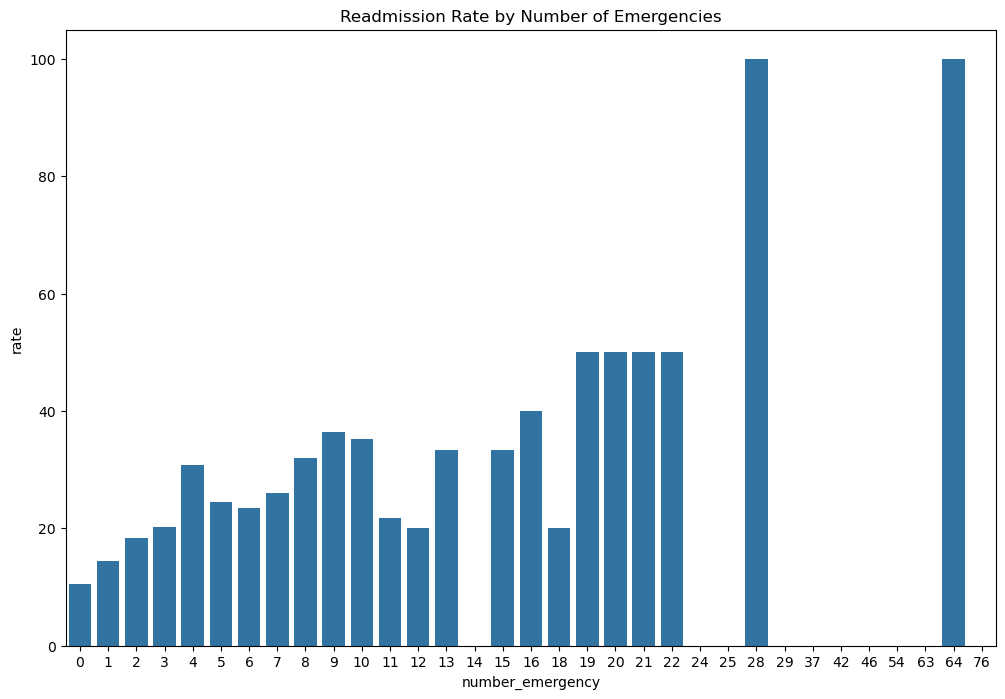

In [64]:
n_emergency['rate'] = 100 * n_emergency['sum'] / n_emergency['count']



plt.figure(figsize=(12,8))
sns.barplot(x=n_emergency.index, y=n_emergency['rate'])
plt.title("Readmission Rate by Number of Emergencies")
# plt.show()
plt.savefig('Graphs/ExploratoryGraphs/readmission_rate_num_emergencies.png')

## Heatmap for Feature Correlation Matrix
### The heatmap below is used to determine how much each numerical feature relates to the other one.
### This will also be used for deeper insight into how a feature might impact readmission rates through another feature

This heatmap generates a Pearson Correlation Coefficient  Matrix that compares all the variables to each other
This will be used to spot multi collinearity between variables
It will also be used to spot important variables that have a strong correlation with being readmitted

In [20]:
numerical_features = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses'
]

In [21]:
df['readmitted_flag'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
numerical_features.append('readmitted_flag')


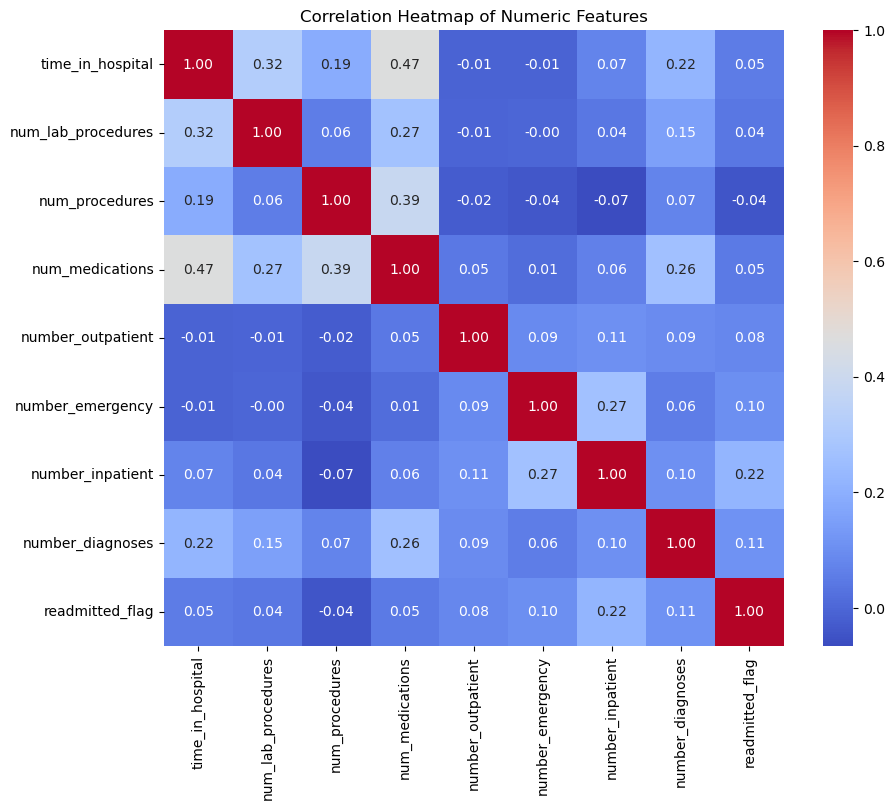

In [65]:
plt.figure(figsize=(10, 8))
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
# plt.show()
plt.savefig('Graphs/ExploratoryGraphs/correlation_heatmap_numeric_features.png')

Looking at this matrix there seems to be a strong correlation between time in hospital and number of medications, this makes sense since it takes time to give medications in a hospital, same goes for number of procedures and lab procedures with number of medications since most procedures come with medications

The variable with the strongest correlation with being readmitted is number_inpatient, those who stayed overnight. This might be because patients who stay overnight might need more care overtime. 

Of course all of these coefficeints would need to be above 0.3 for a weak positive and above .5 for a moderate to strong positive correlation. So this should be considered when looking at these correlation coefficients

## Logistic Regression Model for Predicting Patient Readmission Outcomes
### This section will predict whether a patient will be readmitted or not using the readmitted flag (0, 1) and the following features
- time_in_hospital
- num_lab_procedures
- num_procedures
- num_medications
- number_inpatient
- number_emergency
- number_outpatient
- number_diagnoses
- age
- gender
- admission_type_id
- discharge_disposition_id
- admission_source_id

We are using logisitc regression because its a baseline for binary classification and it is easy to interpret for determining if someone was readmitted or not

In [23]:
features = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_inpatient',
    'number_emergency',
    'number_outpatient',
    'number_diagnoses',
    'age',           # needs to be encoded
    'gender',        # needs to be encoded
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
]


In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 2. Preprocessing Pipeline

In [24]:


# Define X and y, split features and targets
X = df[features] # all features
y = df['readmitted_flag'] # what we are trying to predict, the "target"

# One-hot encode categorical features that are text/category labels
categorical_features = ['age', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
numeric_features = [col for col in features if col not in categorical_features]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features), # no change (passthrough) to numeric columns
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # OneHotEncoder to categorical ones
])





C:\Users\craig\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10980
           1       0.64      0.46      0.53      9374

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.61     20354
weighted avg       0.63      0.63      0.62     20354



## 3. Logistic Regression

In [51]:
# creating the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor), # this pipeline links the preprocessing step with the model itself
    ('classifier', LogisticRegression(max_iter=1000)) # cleans the code ensures same steps are applied consistently
])
# Train/test split
# splits dataset, train on one portion and test on another, avoids overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training and Evaluating the model
# model learns from training set and predicts on the test set
# Fit model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
# classification report gives 
# Precision (how many predicted postives were actual positives)
# Recall (how many actual positives were correctly found)
# F1 score (balance between precision and recall)
# Accuracy (overall correctness)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10980
           1       0.64      0.46      0.53      9374

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.61     20354
weighted avg       0.63      0.63      0.62     20354



C:\Users\craig\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
import joblib

In [26]:
joblib.dump(pipeline, "../models/logistic_model.pkl") # stores model for deployment later

['../models/logistic_model.pkl']

## Logistic Regression Evaluation

In [29]:
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
54,cat__discharge_disposition_id_28.0,1.050550
43,cat__discharge_disposition_id_15.0,0.852828
69,cat__admission_source_id_20.0,0.789652
49,cat__discharge_disposition_id_22.0,0.781440
33,cat__discharge_disposition_id_5.0,0.724046
...,...,...
63,cat__admission_source_id_9.0,-0.615805
8,cat__age_[0-10),-0.726230
41,cat__discharge_disposition_id_13.0,-1.572114
42,cat__discharge_disposition_id_14.0,-2.287026


the logistic model identified specific discharge disposition categories as the strongest predictors. The most extreme coefficients were:

Discharge to psychiatric hospital (id = 28) → positive coefficient

Discharge to hospice (id = 11, 14) → large negative coefficients

This suggests that where a patient goes after discharge has a major influence on readmission likelihood — hospice patients, understandably, are less likely to be readmitted, while discharges to psychiatric facilities correlate with higher return rates.

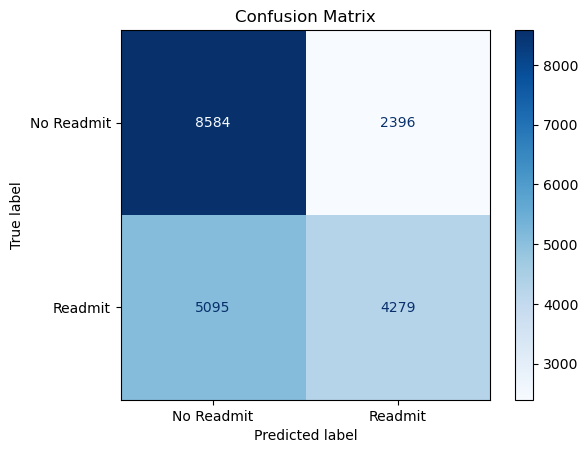

In [67]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict and plot
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmit", "Readmit"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
# plt.show()
plt.savefig('Graphs/LogisticRegressionOutputs/confusion_matrix.png')

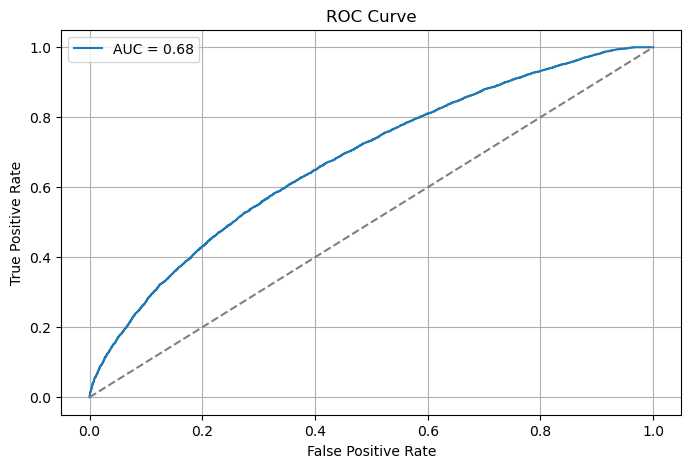

In [68]:
# Plot ROC Curve + AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilities for class 1
y_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig('Graphs/LogisticRegressionOutputs/ROC_curve.png')

## 4. Random Forest
This section of the notebook is used to train the Random Forest machine learning model and plot its features to show its differences to the logistic regression model

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [38]:
# Training

# Random Forest ML pipeline and classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # same preprocessor as logistic pipeline
    ('rf', RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.62      0.69      0.65     10980
           1       0.58      0.51      0.54      9374

    accuracy                           0.60     20354
   macro avg       0.60      0.60      0.60     20354
weighted avg       0.60      0.60      0.60     20354

ROC AUC: 0.6408632342762585


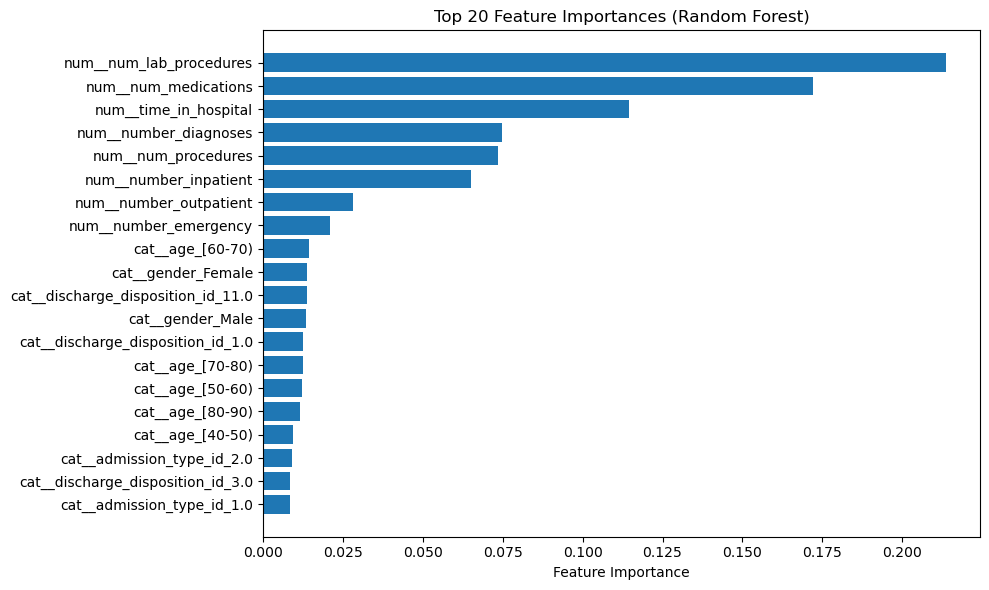

In [69]:
# Plotting Feature Importance

# Get feature importances
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['rf'].feature_importances_

# Create DataFrame for plotting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.show()
plt.savefig('Graphs/RandomForestOutputs/feature_importance.png')

In [44]:
feat_df

,Feature,Importance
1,num__num_lab_procedures,0.213624
3,num__num_medications,0.172071
0,num__time_in_hospital,0.114628
7,num__number_diagnoses,0.074900
2,num__num_procedures,0.073558
4,num__number_inpatient,0.065082
6,num__number_outpatient,0.028214
5,num__number_emergency,0.021020
14,cat__age_[60-70),0.014304
18,cat__gender_Female,0.013891


In [49]:
feat_df.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,num__num_lab_procedures,0.213624
3,num__num_medications,0.172071
0,num__time_in_hospital,0.114628
7,num__number_diagnoses,0.074900
2,num__num_procedures,0.073558
4,num__number_inpatient,0.065082
6,num__number_outpatient,0.028214
5,num__number_emergency,0.021020
14,cat__age_[60-70),0.014304
18,cat__gender_Female,0.013891


The most important features for predicting readmission were:

Number of lab procedures (21%)

Number of medications (17%)

Time in hospital (11%)

Number of diagnoses (7.5%)

These suggest that overall intensity of treatment and care complexity correlate more strongly with likelihood of readmission.

In [52]:
joblib.dump(rf_pipeline, "../models/random_forest_model.pkl") # stores random forest model for deployment later

['../models/random_forest_model.pkl']

## 5. Model Comparison
# Interpretation:

- **Logistic Regression** showed stronger overall precision and ROC AUC, making it more conservative in flagging patients as likely to be readmitted (fewer false positives).
- **Random Forest** delivered higher recall and F1 score for readmission cases, making it more effective at identifying true readmissions — though at the cost of more false positives.
- If minimizing missed readmissions is the top priority, **Random Forest** may be more appropriate.
- If interpretability and reducing false positives matter more, **Logistic Regression** is a solid, explainable baseline.

# Clinical Relevance:

In healthcare, the cost of missing a true readmission can be higher than issuing a false alert. Therefore, **Random Forest’s higher recall** may be more valuable in a hospital setting — especially for early intervention or care management programs.


Higher recall means we mighty have more false positives and higher precision means we might have more false negatives. In this scenario we would want higher false positives because the consequences are higher for missing a readmission then flagging someone falsely.


**Almost done just save the charts you made from evaluating your models and exploring data. Then we should be ready to push to github after removing your passwords from your database and url from the beginnning of the notebook. Also examine all files in your folder to make sure nothing has your databse password or url before pushing**

**DELETE THIS CELL BEFORE PUSHING**

In [76]:
# Rename & simplify columns for dashboard readability
df_dashboard = df.copy()
df_dashboard = df_dashboard.rename(columns={
    'readmitted': 'Readmitted',
    'num_lab_procedures': 'LabProcedures',
    'num_medications': 'Medications',
    'time_in_hospital': 'TimeInHospital',
    'discharge_disposition_id': 'DischargeID',
    'admission_source_id': 'AdmissionSource',
    # include any other needed renames
})


In [77]:
df_dashboard

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,DischargeID,AdmissionSource,TimeInHospital,...,metformin-pioglitazone,change,diabetesMed,Readmitted,description_x,description_y,description,readmitted_flag,meds_bucket,lab_proce_bucket
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,NO,None,Physician Referral,Not Mapped,0,0-10,41-60
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Ch,Yes,>30,Emergency,Emergency Room,Discharged to home,1,11-20,41-60
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,Yes,NO,Emergency,Emergency Room,Discharged to home,0,11-20,0-20
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home,0,11-20,41-60
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home,0,0-10,41-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Ch,Yes,>30,Emergency,Emergency Room,Discharged/transferred to SNF,1,11-20,41-60
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,No,Yes,NO,Emergency,Transfer from a Skilled Nursing Facility (SNF),Discharged/transferred to ICF,0,11-20,21-40
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home,0,0-10,41-60
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Ch,Yes,NO,Urgent,Emergency Room,Discharged/transferred to SNF,0,21-30,41-60


In [80]:
bins=[0, 20, 40, 60, 80, 100, 120, 140]
labels=['0–20', '21–40', '41–60', '61–80', '81-100', '101-120', '121-140']

In [81]:


# Optional: Add age_group column if not already present
bu = pd.cut(
    df_dashboard['age'], bins=bins, labels=labels)

TypeError: '<' not supported between instances of 'int' and 'str'

In [79]:

bins=[0, 20, 40, 60, 80, 100, 120, 140]
labels=['0–20', '21–40', '41–60', '61–80', '81-100', '101-120', '121-140']
# Optional: Add age_group column if not already present
df_dashboard['AgeGroup'] = pd.cut(
    df_dashboard['age'], bins=bins, labels=labels)


TypeError: '<' not supported between instances of 'int' and 'str'

In [75]:


# Save to CSV
df_dashboard.to_csv("data/processed/final_readmission_data.csv", index=False)


TypeError: '<' not supported between instances of 'int' and 'str'